In [1]:
#!/usr/bin/env python
# coding: utf-8


import numpy as np
import time as T
from joblib import Parallel, delayed
from scipy.interpolate import griddata,interpn,RegularGridInterpolator
import math
import os
import datetime
import cv2
from ftplib import FTP
import rioxarray
import xarray as xr
import paramiko
from scp import SCPClient
import subprocess
import datetime as dt

target ='/data01/people/liwei/AC_test/'

SZA_PATH = '/data01/GEO/INPUT/ANGLE/Solar_Zenith_Angle_u2/'
SAA_PATH = '/data01/GEO/INPUT/ANGLE/Solar_Azimuth_Angle_u2/'
VZA_PATH = '/data01/GEO/INPUT/ANGLE/Viewer_Zenith_Angle/AHI_VZA_20.dat'
VAA_PATH = '/data01/GEO/INPUT/ANGLE/Viewer_Azimuth_Angle/AHI_VAA_20.dat'

LUT_PATH = '/data01/GEO/INPUT/LUT/'
CAMS_PATH = '/data01/GEO/INPUT/ATMOSPHERE/'
DN_PATH = '/data01/GEO/INPUT/'
CAMS_AERO_PATH = '/data01/GEO/INPUT/AEROSOL_TYPE/'
AL_PATH = '/data01/GEO/INPUT/ELEVATION_GEO/AHI/MERIT_DEM_AHI_20km.dat'

res = 0.02
u_lat,d_lat = 60,-60
l_lon,r_lon = 85,205

row_AHI = 6000
col_AHI = 6000

lat_x = np.linspace(60 - res/2 ,-60 + res/2,row_AHI)
lon_y = np.linspace(85 + res/2 ,205 - res/2,col_AHI)


/data01/people/liwei/anaconda3/envs/python36/lib/python3.6/site-packages/paramiko/transport.py:33: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography.hazmat.backends import default_backend


In [2]:

   
class H8_data:

    def __init__(self , account , pw , band , band_number , date):
        self.account = account
        self.pw = pw
        self.band = band
        self.band_number = band_number
        self.date = date
    
    def get_path(self):
        return '/data01/GEO/ORGDATA/H8AHI/hmwr829gr.cr.chiba-u.ac.jp/gridded/FD/V20151105/' + self.date[0:6] + '/' + self.band.upper() + '/'

    def get_filename(self):
        return self.date + "." + self.band + "." + self.band_number + ".fld.geoss.bz2"
    
    def DN2TBB(self,data):
        LUT=np.loadtxt(DN_PATH + 'count2tbb_v102/' + self.band + "." + self.band_number)
        return LUT[data,1]
    
    def file_path(self):
        return self.get_path() + self.get_filename() 
                 
    def download_H8data(self):
        client = paramiko.SSHClient()
        client.load_system_host_keys()
        client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        client.connect(hostname='10.4.123.47', port=22, username=self.account, password=self.pw)
        scp = SCPClient(client.get_transport())
        sftp = client.open_sftp()

        try :
            sftp.stat(self.file_path())

        except FileNotFoundError:
            print("File Not Found")
            return 'No data'

        else:
            scp.get(self.file_path(), folder_original+'/')
            p = subprocess.Popen('lbzip2 -d {}{}'.format(folder_original+'/',self.file_path()[-33:]),shell=True)
            p.communicate()
            print ('Himawari8/AHI data Processed Finish')
            return folder_original + '/' + self.get_filename()[:-4]
            
    def read_H8data(self):
        H8_file_path = self.download_H8data()
        if self.band == "vis":
            sr = 12000
        elif self.band == "ext":
            sr = 24000
        else:
            sr = 6000
        if H8_file_path != 'No data':
            with open(H8_file_path,'rb') as fp:
                data = np.frombuffer(fp.read(),dtype='>u2').reshape(sr,sr)
                data = self.DN2TBB(data)
                data = data/100

            print("data reading finish")
            return data
        else:
            return 'No data'
        

In [75]:

   
# class H8_data:

#     def __init__(self ,band , band_number , date):
#         self.band = band
#         self.band_number = band_number
#         self.date = date
    
#     def get_path(self):
#         return '/data01/GEO/ORGDATA/H8AHI/hmwr829gr.cr.chiba-u.ac.jp/gridded/FD/V20151105' + self.date[0:6] + '/' + self.band.upper() + '/'

#     def get_filename(self):
#         return self.date + "." + self.band + "." + self.band_number + ".fld.geoss.bz2"
    
#     def DN2TBB(self,data):
#         LUT=np.loadtxt(DN_PATH + 'count2tbb_v102/' + self.band + "." + self.band_number)
#         return LUT[data,1]
    
#     def file_path(self):
#         return self.get_path() + self.get_filename() 
                 
#     def download_H8data(self):
        
#         p = subprocess.Popen('lbzip2 -d -k {} '.format(file_path),shell=True)
#         p.communicate()
#         print ('Himawari8/AHI data Processed Finish')
#         return self.file_path()[:-4]

#     def read_H8data(self):
#         H8_file_path = self.download_H8data()
#         if self.band == "vis":
#             sr = 12000
#         elif self.band == "ext":
#             sr = 24000
#         else:
#             sr = 6000
#         if H8_file_path != 'No data':
#             with open(H8_file_path,'rb') as fp:
#                 data = np.frombuffer(fp.read(),dtype='>u2').reshape(sr,sr)
#                 data = self.DN2TBB(data)
#                 data = data/100

#             print("data reading finish")
#             return data
#         else:
#             return 'No data'
        

In [3]:
# class JAXA_data:
#     def __init__(self,account,YYYY,MM,DD,HH):
#         self.account = account
#         self.YYYY = YYYY
#         self.MM = MM
#         self.DD = DD
#         self.HH = HH
        
#     def download_JAXA(self):
#         ftp_addr = 'ftp.ptree.jaxa.jp'
#         f=FTP(ftp_addr)
#         f.login(self.account,'SP+wari8')
#         remote_filepath = '/pub/model/ARP/MS/bet/' + self.YYYY + self.MM + '/' + self.DD + '/'
#         f.cwd(remote_filepath)
#         list=f.nlst()
#         bufsize=1024
#         for name in list:
#             if name[13:17]== self.HH + '00':
#                 data=open(folder_original + name ,'wb')
#                 filename='RETR '+ name
#                 f.retrbinary(filename,data.write,bufsize)
#                 f.quit()
#                 return folder_original + name
    
    
#     def read_JAXA(self):
#         AOT_path = self.download_JAXA()
#         ds = xr.open_dataset(AOT_path)
#         aot550=ds['od550aer']
#         AOT550=aot550.interp(lon=lon_y,lat=lat_x,method="nearest")
#         AOT550=AOT550.values
#         AOT550[AOT550>=max(AOT)] = max(AOT)-(1/10000)
#         AOT550[AOT550<=min(AOT)] = min(AOT)+(1/10000)
    
        
#         bc = ds['od550bc'].interp(lon=lon_y,lat=lat_x,method="nearest")
#         so4 = ds['od550so4'].interp(lon=lon_y,lat=lat_x,method="nearest")
#         oa = ds['od550oa'].interp(lon=lon_y,lat=lat_x,method="nearest")
#         dust = ds['od550dust'].interp(lon=lon_y,lat=lat_x,method="nearest")
#         ss = ds['od550ss'].interp(lon=lon_y,lat=lat_x,method="nearest")
        
        
#         DL_6S = np.array(dust).reshape(row_AHI,col_AHI)
#         SL_6S = np.array(so4).reshape(row_AHI,col_AHI) + np.array(bc).reshape(row_AHI,col_AHI)
#         OC_6S = np.array(ss).reshape(row_AHI,col_AHI)
#         WS_6S = np.array(oa).reshape(row_AHI,col_AHI)

#         Total = DL_6S + SL_6S + OC_6S + WS_6S

#         precent_DL_6S = DL_6S / Total
#         precent_SL_6S = SL_6S / Total
#         precent_OC_6S = OC_6S / Total
#         precent_WS_6S = WS_6S / Total
#         P = np.dstack((precent_DL_6S,precent_WS_6S,precent_OC_6S,precent_SL_6S))
        
#         Aerosol_type = np.full((row_AHI,col_AHI),np.nan)
        
#         for i in range(row_AHI):
#             for j in range(col_AHI):
#                 if max(P[i,j,:]) == precent_OC_6S[i,j]:
#                     Aerosol_type[i,j] = 1
#                 else:
#                     Aerosol_type[i,j] = 0
                    
#         return np.array(AOT550).reshape(row_AHI,col_AHI),Aerosol_type

In [3]:
class LUT_interpolation:
    def __init__(self,LUT_PATH):
        self.LUT_path = LUT_PATH
    
    def LUT_interpolation(self):
        X1 = np.loadtxt(self.LUT_path + "01_band5.csv",delimiter=",").reshape(2,8,12,5,17,17,19)
        X2 = np.loadtxt(self.LUT_path + "02_band5.csv",delimiter=",").reshape(2,8,12,5,17,17,19)
        X3 = np.loadtxt(self.LUT_path + "03_band5.csv",delimiter=",").reshape(2,8,12,5,17,17,19)
        # return X1, X2, X3
        
        fn1 = RegularGridInterpolator((aero_type,water,AOT,al,sza,vza,raa),X1,bounds_error=False,fill_value=np.nan)
        fn2 = RegularGridInterpolator((aero_type,water,AOT,al,sza,vza,raa),X2,bounds_error=False,fill_value=np.nan)
        fn3 = RegularGridInterpolator((aero_type,water,AOT,al,sza,vza,raa),X3,bounds_error=False,fill_value=np.nan)
        return fn1,fn2,fn3

In [4]:
class AHI_angle:
    def __init__(self,date):
        self.date = date        
    def read_angle_data(self):
        
        AHI_date = self.date[4:11]
        
        sza_file_name = 'AHI_SZA_2020{}5.dat'.format(AHI_date)
        saa_file_name = 'AHI_SAA_2020{}5.dat'.format(AHI_date)
        
        with open(SZA_PATH + sza_file_name,'rb') as fp:
            AHI_SZA = np.frombuffer(fp.read(),dtype='u2').reshape(3000,3000) / 100
            AHI_SZA=cv2.resize(np.array(AHI_SZA,dtype='float64'),(row_AHI,col_AHI),interpolation=cv2.INTER_NEAREST)
        
        with open(SAA_PATH + saa_file_name,'rb') as fp:
            AHI_SAA = np.frombuffer(fp.read(),dtype='u2').reshape(3000,3000) / 100
            AHI_SAA=cv2.resize(np.array(AHI_SAA,dtype='float64'),(row_AHI,col_AHI),interpolation=cv2.INTER_NEAREST)
        
        return AHI_SZA,AHI_SAA

In [5]:
class CAMS_data:
    def __init__(self,YYYY,MM,DD,HH,MIN):
        self.YYYY = YYYY
        self.MM = MM
        self.DD = DD
        self.HH = HH
        self.MIN = MIN
        
    def read_CAMS(self):
        
        dtime = dt.datetime(int(self.YYYY),int(self.MM),int(self.DD),int(self.HH),int(self.MIN)+5)
        ds = xr.open_dataset(CAMS_PATH + self.YYYY + self.MM + self.DD + '.nc')
        ds = ds.interp(time = dtime,method = 'linear')
        ds = ds.interp(longitude=lon_y,latitude=lat_x,method="nearest")
        
        OZ = ds['gtco3'].values        
        WV = ds['tcwv'].values        
        AOT550 = ds['aod550'].values
#         Atmosphere data Unit conversion
        WV = WV/10
        OZ = OZ*46.6975764


#         Processing water vapor and ozone max and min
        OZ[OZ>=max(ozone)] = max(ozone)-(1/10000)
        OZ[OZ<=min(ozone)] = min(ozone)+(1/10000)
        WV[WV>=max(water)] = max(water)-(1/10000)
        WV[WV<=min(water)] = min(water)+(1/10000)
        AOT550[AOT550>=max(AOT)] = max(AOT)-(1/10000)
        AOT550[AOT550<=min(AOT)] = min(AOT)+(1/10000)
        
        return np.array(OZ).reshape(row_AHI,col_AHI),np.array(WV).reshape(row_AHI,col_AHI),np.array(AOT550).reshape(row_AHI,col_AHI)

    def read_CAMS_AERO(self):
        
        dtime = dt.datetime(int(self.YYYY),int(self.MM),int(self.DD),int(self.HH),int(self.MIN)+5)
        
        ds = xr.open_dataset(CAMS_AERO_PATH + self.YYYY + self.MM + self.DD + '.nc')
        ds = ds.interp(time = dtime,method = 'linear')
        ds = ds.interp(longitude=lon_y,latitude=lat_x,method="nearest")
        
        bc = ds['bcaod550'].values
        du = ds['duaod550'].values
        om = ds['omaod550'].values
        ss = ds['ssaod550'].values
        su = ds['suaod550'].values

        DL_6S = np.array(du)
        SL_6S = np.array(su) + np.array(bc)
        OC_6S = np.array(ss)
        WS_6S = np.array(om)

        Total = DL_6S + SL_6S + OC_6S + WS_6S

        precent_DL_6S = DL_6S / Total
        precent_SL_6S = SL_6S / Total
        precent_OC_6S = OC_6S / Total
        precent_WS_6S = WS_6S / Total
        P = np.dstack((precent_DL_6S,precent_WS_6S,precent_OC_6S,precent_SL_6S))
        Aerosol_type = np.where(np.amax(P,axis = 2) == precent_OC_6S,1,0)
        
        return Aerosol_type

In [6]:
def H8_Process(ACCOUNT,PW,Band,Band_number,Date):
    data = H8_data(ACCOUNT,PW,Band,Band_number,Date).read_H8data()
    return data

# def remove_original_file(path):
#     subprocess.Popen('rm -rf {}'.format(path))
    
    
def mkdir(path):
    folder = os.path.exists(path) 
    if not folder:
        os.makedirs(path)
        
def Time_split(time):
    YYYY = time.strftime('%Y')
    MM = time.strftime('%m')
    DD = time.strftime('%d')
    HH = time.strftime('%H')
    MIN = time.strftime('%M')
    date = YYYY + MM + DD + HH + MIN
    return YYYY,MM,DD,HH,MIN,date
        
        
def calculate_6s_band5(i):
    Aero_input = Aerosol_type[i,:]
    WV_input = WV[i,:]
    AOT550_input = AOT550[i,:]
    RAA_input = RAA[i,:]
    SZA_input = AHI_SZA[i,:]
    VZA_input = AHI_VZA[i,:]
    AL_input = AHI_AL[i,:]
    xi = np.array([Aero_input,WV_input,AOT550_input,AL_input,SZA_input,VZA_input,RAA_input])
    xi = xi.T
    xa = fn1(xi)
    xb = fn2(xi)
    xc = fn3(xi)
    y = xa*AHI_data[i,:]-xb
    SR = y/(1+xc*y)
    return SR

sza = np.linspace(0,80,17)
vza = np.linspace(0,80,17)
water = np.linspace(0,7,8)
ozone = np.linspace(0.2,0.4,5)
AOT = np.array([0.01,0.05,0.1,0.15,0.2,0.3,0.4,0.6,0.8,1.0,1.5,2.0])
raa = np.linspace(0,180,19)
al = np.linspace(0,8,5)
aero_type = np.array([0,1])


fn1,fn2,fn3 = LUT_interpolation(LUT_PATH).LUT_interpolation()

with open(VZA_PATH,'rb') as fp:
    AHI_VZA = np.frombuffer(fp.read(),dtype='u2').reshape(row_AHI,col_AHI) / 100
with open(VAA_PATH,'rb') as fp:
    AHI_VAA = np.frombuffer(fp.read(),dtype='u2').reshape(row_AHI,col_AHI) / 100
with open(AL_PATH ,'rb') as fp:
    AHI_AL = np.frombuffer(fp.read(),dtype='u2').reshape(row_AHI,col_AHI) / 1000
AHI_AL[AHI_AL>=max(al)] = max(al)

In [7]:
date_start = '2020-01-01 00:00'
date_end = '2020-01-01 00:00'
date_t = dt.timedelta(minutes=10)
date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
date_time_now = date_s
while date_time_now <= date_e:
    start_time = T.time()
    # date_dl_str = date_time_now.strftime("%Y-%m-%d %H:%M" )
    
    YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)    
    print("start processing {}".format(date))
    # make dir
    folder_original = target + date +'_original/'
    folder_AC = target+date+'_AC/'
    mkdir(folder_original)
    mkdir(folder_AC)
    # Download AHI
    AHI_data = H8_Process('liwei','liwei00','sir','01',date)
    
    if AHI_data == 'No data':
        continue

    # Solar angle
    print('Start reading Angle data')
    AHI_SZA,AHI_SAA = AHI_angle(date).read_angle_data()
    
    RAA = abs(AHI_SAA - AHI_VAA)
    RAA[RAA>180]=360-RAA[RAA>180]
    
    print('Angle data read finished')
    print('Start reading Atmospheric data')
    OZ,WV,AOT550 = CAMS_data(YYYY,MM,DD,HH,MIN).read_CAMS()
    Aerosol_type = CAMS_data(YYYY,MM,DD,HH,MIN).read_CAMS_AERO()
    print('Atmospheric data read finished')
    
    SR = Parallel(n_jobs=-1)(delayed(calculate_6s_band5)(i) for i in range(row_AHI))
    # Save file and remove download input data
    SR=np.array(SR).reshape(row_AHI,col_AHI)
    SR_file=open(folder_AC+'/'+date+'_b05.dat','wb')
    SR.astype('f4').tofile(SR_file)
    SR_file.close()
#                 remove_original_file(folder_original)
    end_time=T.time()
    TIME=end_time-start_time
    print('time: {:.1f} secs, {:.1f} mins,{:.1f} hours'.format(TIME,TIME/60,TIME/3600))
    print("delete file finish")
    
    
    date_time_now = date_time_now + date_t

start processing 202001010000
Himawari8/AHI data Processed Finish
data reading finish
Start reading Angle data


/data01/people/liwei/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Angle data read finished
Start reading Atmospheric data
Atmospheric data read finished
time: 75.8 secs, 1.3 mins,0.0 hours
delete file finish


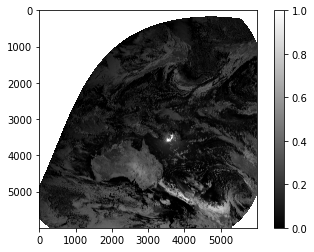

In [9]:
import matplotlib.pyplot as plt
plt.imshow(SR,cmap='gray',vmax=1,vmin=0)
plt.colorbar()